<a href="https://colab.research.google.com/github/saikrishna1108/5106_Final_Project/blob/main/Transformer_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [71]:
!git clone https://github.com/saikrishna1108/5106_Final_Project.git

Cloning into '5106_Final_Project'...
remote: Enumerating objects: 813, done.
remote: Counting objects: 100% (689/689), done.
remote: Compressing objects: 100% (667/667), done.
remote: Total 813 (delta 89), reused 527 (delta 21), pack-reused 124
Receiving objects: 100% (813/813), 4.02 MiB | 15.01 MiB/s, done.
Resolving deltas: 100% (89/89), done.
Updating files: 100% (651/651), done.


In [78]:
import os
os.chdir('/content/drive/MyDrive/rtml/5106_Final_Project/5106_Final_Project')

In [79]:
import os
import torch
import numpy as np
import random
from torch.utils.data import DataLoader, Dataset
import math

class SpeedDataset(Dataset):
    def __init__(self, directory, sequence_length=5, augment=True):
        self.data = []
        self.sequence_length = sequence_length
        # self.num_classes = (105 - 30) // 10 + 1  # Speed classes from 30-39, ..., 100-105
        self.augment = augment  # Enable or disable augmentation
        self.preprocess_data(directory)
        self.normalize_features()

    def preprocess_data(self, directory):
        for filename in os.listdir(directory):
            if filename.endswith('.txt'):
                speed = float(filename.split('_')[-1].replace('.txt', ''))
                # speed_class = 0 if speed < 30 else (int(speed) - 30) // 10
                filepath = os.path.join(directory, filename)
                with open(filepath, 'r') as file:
                    track_data = {}
                    for line in file:
                        points = line.strip().split(',')
                        if len(points) == 6:
                            frame, track_id, x1, y1, x2, y2 = map(float, line.strip().split(','))
                        if len(points) == 7:
                            frame,class_id, track_id, x1, y1, x2, y2 = map(float, line.strip().split(','))
                        if track_id not in track_data:
                            track_data[track_id] = []
                        track_data[track_id].append([x1, y1, x2, y2])

                    for track_id, frames in track_data.items():
                        if len(frames) >= self.sequence_length:
                            features = self.extract_features(frames)
                            overlap = 5  # Overlap for sequence extraction
                            for start_idx in range(0, len(features) - self.sequence_length + 1, self.sequence_length - overlap):
                                end_idx = start_idx + self.sequence_length
                                sequence = features[start_idx:end_idx]
                                self.data.append((sequence, speed))

    def extract_features(self, frames):
        features = []
        for i in range(1, len(frames)):
            current_frame = frames[i]
            previous_frame = frames[i-1]
            features.append(self.compute_frame_features(current_frame, previous_frame))
        return features

    def compute_frame_features(self, current_frame, previous_frame):
        x1, y1, x2, y2 = current_frame
        px1, py1, px2, py2 = previous_frame

        width, height = x2 - x1, y2 - y1
        p_width, p_height = px2 - px1, py2 - py1

        x2_change = x2 - px2
        y2_change = y2 - py2
        x1_change = x1 - px1
        y1_change = y1 - py1

        width_change = width - p_width
        height_change = height - p_height
        area_change = (width * height) - (p_width * p_height)
        perimeter_change = (2 * (width + height)) - (2 * (p_width + p_height))

        center_x, center_y = (x1 + x2) / 2, (y1 + y2) / 2
        p_center_x, p_center_y = (px1 + px2) / 2, (py1 + py2) / 2
        center_x_change = center_x - p_center_x
        center_y_change = center_y - p_center_y
        distance_moved = math.sqrt(center_x_change ** 2 + center_y_change ** 2)

        velocity = distance_moved/0.03  # Assuming constant frame rate
        p_velocity = (math.sqrt((px2 - px1) ** 2 + (py2 - py1) ** 2))/0.03
        acceleration = abs(velocity - p_velocity)

        feature_vector = [x1_change, y1_change, x2_change, y2_change,
                          center_x_change, center_y_change, distance_moved, velocity, acceleration]
        return feature_vector

    def normalize_features(self):
        all_features = [feature for sequence, _ in self.data for feature in sequence]
        all_features = np.array(all_features)
        self.mean = np.mean(all_features, axis=0)
        self.std = np.std(all_features, axis=0)
        for i, (sequence, speed) in enumerate(self.data):
            normalized_sequence = (sequence - self.mean) / (self.std)
            self.data[i] = (normalized_sequence, speed)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        inputs, output = self.data[idx]
        if self.augment:
            inputs = self.apply_augmentation(inputs)
        return torch.tensor(inputs, dtype=torch.float32), torch.tensor(output, dtype=torch.float32)

    def apply_augmentation(self, inputs):
        if random.random() > 0.9:
            inputs = self.add_noise(inputs)
        if random.random() > 0.99:
            inputs = self.time_shift(inputs, shift=random.choice([-1, 1]))
        if random.random() > 0.95:
            inputs = self.scale_features(inputs, scale=random.uniform(0.9, 1.1))
        if random.random() > 0.98:
            inputs = self.mirror_features(inputs)
        return inputs

    def add_noise(self, features, noise_level=0.05):
        noise = np.random.normal(0, noise_level, features.shape)
        return features + noise

    def time_shift(self, features, shift=1):
        if shift > 0:
            return np.vstack([np.zeros((shift, features.shape[1])), features[:-shift]])
        elif shift < 0:
            return np.vstack([features[-shift:], np.zeros((-shift, features.shape[1]))])
        return features

    def scale_features(self, features, scale=1.1):
        return features * scale

    def mirror_features(self, features):
        features_copy = features.copy()
        features_copy[:, [0, 2]] = -features_copy[:, [0, 2]]  # Assume these indices are the x-coordinates
        return features_copy


In [80]:
import torch

# Check for CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [81]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=0.1)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

class SpeedPredictor(nn.Module):
    def __init__(self, sequence_length, feature_size, hidden_dim, output_size):
        super(SpeedPredictor, self).__init__()
        self.embedding = nn.Conv1d(in_channels=feature_size, out_channels=hidden_dim, kernel_size=1)
        self.pos_encoder = PositionalEncoding(hidden_dim)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=4, dim_feedforward=hidden_dim * 4, dropout=0.4)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=2)
        self.fc1 = nn.Linear(hidden_dim, 16)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(16, output_size)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.embedding(x)
        x = x.permute(0, 2, 1)
        x = x.permute(1, 0, 2)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        x = x.permute(1, 0, 2)  # Switch back to (batch, seq_len, features)
        x = x[:, -1, :]  # Only use the last sequence output for prediction
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight)
        nn.init.constant_(m.bias, 0)


In [82]:
def train_and_validate(model, train_loader, val_loader, criterion, optimizer,scheduler, epochs):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        # Training
        model.train()
        total_train_loss = 0
        for inputs, speeds in train_loader:
            inputs, speeds = inputs.to(device), speeds.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            outputs = outputs.squeeze()
            if outputs.shape != speeds.shape:
                outputs = outputs[:speeds.size(0)]
            loss = criterion(outputs, speeds)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
        scheduler.step()
        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for inputs, speeds in val_loader:
                inputs, speeds= inputs.to(device), speeds.to(device)
                outputs = model(inputs)
                outputs = outputs.squeeze()

                # if len(outputs.shape) == 1:
                # # Remove the slicing operation if the tensor has a single dimension
                #   outputs = outputs
                # else:
                #   print(outputs.shape)
                #   print(speeds.shape)
                # outputs = outputs[:speeds.size(0)]

                # Adjust the slicing operation if the tensor has multiple dimensions
                  # outputs = outputs[:speeds.size(0)]

                # if outputs.shape != speeds.shape:
                #     print(outputs.shape)
                #     print(speeds.shape)
                #     outputs = outputs[:speeds.size(0)]
                loss = torch.sqrt(criterion(outputs, speeds))
                total_val_loss += loss.item()
        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        if epoch % 1 ==0:
            print(f'Epoch {epoch+1}/{epochs}, MSE training Loss: {avg_train_loss:.4f}, RMSE validation Loss: {avg_val_loss:.4f}')

    return train_losses, val_losses


In [83]:
import torch
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR

train_dataset = SpeedDataset('./Dataset/Train/', sequence_length=15)
test_dataset = SpeedDataset('./Dataset/Test/', sequence_length=15)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [84]:
# Model, Loss, and Optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SpeedPredictor(sequence_length=15, feature_size=9, hidden_dim=128, output_size=1)
model.to(device)
model.apply(init_weights)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Scheduler for learning rate adjustment
scheduler = ExponentialLR(optimizer, gamma=0.9999999999)
train_losses,val_losses = train_and_validate(model, train_loader, test_loader, criterion, optimizer, scheduler, epochs=100)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch 1/100, MSE training Loss: 2409.6479, RMSE validation Loss: 29.7406
Epoch 2/100, MSE training Loss: 1025.1372, RMSE validation Loss: 18.6599
Epoch 3/100, MSE training Loss: 835.6066, RMSE validation Loss: 18.4449
Epoch 4/100, MSE training Loss: 817.7835, RMSE validation Loss: 16.5134
Epoch 5/100, MSE training Loss: 688.1454, RMSE validation Loss: 13.3917
Epoch 6/100, MSE training Loss: 640.0196, RMSE validation Loss: 15.9406
Epoch 7/100, MSE training Loss: 617.8111, RMSE validation Loss: 14.0294
Epoch 8/100, MSE training Loss: 582.9496, RMSE validation Loss: 10.2159
Epoch 9/100, MSE training Loss: 585.5854, RMSE validation Loss: 11.1289
Epoch 10/100, MSE training Loss: 578.9644, RMSE validation Loss: 9.8440
Epoch 11/100, MSE training Loss: 552.6962, RMSE validation Loss: 10.6733
Epoch 12/100, MSE training Loss: 556.6585, RMSE validation Loss: 10.7690
Epoch 13/100, MSE training Loss: 574.5235, RMSE validation Loss: 9.0547
Epoch 14/100, MSE training Loss: 552.9215, RMSE validation L

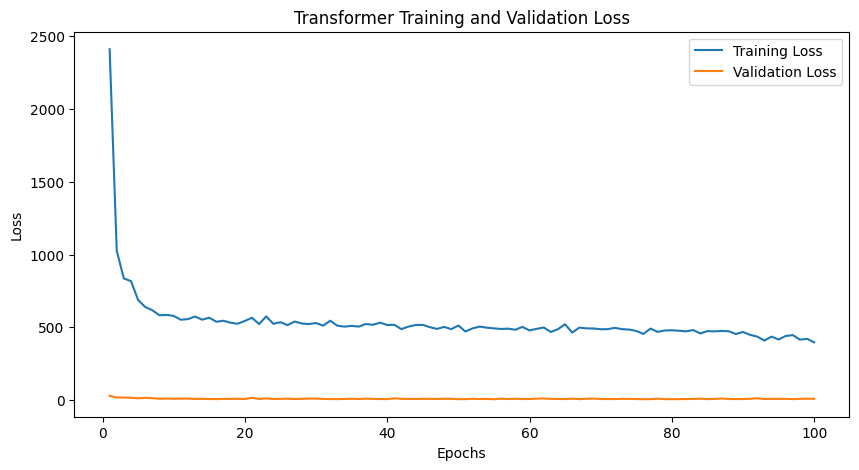

In [85]:
# Plotting training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, 100+1), train_losses, label='Training Loss')
plt.plot(range(1, 100+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Transformer Training and Validation Loss')
plt.legend()
plt.show()

In [86]:

torch.save(model, 'Transformer_Regression_150.pth')


In [87]:
# Load the entire model
model = torch.load('Transformer_Regression_150.pth').to(device)
model.eval()  # Set the model to evaluation mode


SpeedPredictor(
  (embedding): Conv1d(9, 128, kernel_size=(1,), stride=(1,))
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
    )
    (linear1): Linear(in_features=128, out_features=512, bias=True)
    (dropout): Dropout(p=0.4, inplace=False)
    (linear2): Linear(in_features=512, out_features=128, bias=True)
    (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.4, inplace=False)
    (dropout2): Dropout(p=0.4, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, 

In [89]:
import random
def predict_and_compare(model, test_loader):
    model.eval()  # Ensure the model is in evaluation mode
    predictions = []
    actuals = []
    total_loss = 0
    with torch.no_grad():  # No need to track gradients
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            print(outputs.shape)
            print(len(inputs))
            predictions.extend(outputs.squeeze().tolist())
            actuals.extend(targets.tolist())
            loss = torch.sqrt(criterion(outputs, targets))
            if outputs.shape != targets.shape:
                outputs = outputs[:targets.size(0)]
            total_loss += loss.item()
    return predictions, actuals, total_loss/len(test_loader)

test_dataset = SpeedDataset('./Dataset/Test/', sequence_length=15)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
predictions, actuals, loss = predict_and_compare(model, test_loader)

def print_random_predictions(predictions, actuals, num_samples=30):
    if len(predictions) < num_samples:
        num_samples = len(predictions)  # Adjust sample size if predictions are fewer than requested

    # Get random sample indices
    sample_indices = random.sample(range(len(predictions)), num_samples)

    # Print the randomly selected predictions and their actual values
    for idx in sample_indices:
        print(f"Predicted: {predictions[idx]:.4f}, Actual: {actuals[idx]:.4f}")

# Assuming you have already executed the predict_and_compare function
# predictions, actuals = predict_and_compare(model, val_loader)

# Now print randomly selected 30 predictions and their actual values
print_random_predictions(predictions, actuals, 50)
print(loss)


torch.Size([32, 1])
32
torch.Size([32, 1])
32
torch.Size([32, 1])
32
torch.Size([32, 1])
32
torch.Size([32, 1])
32
torch.Size([32, 1])
32
torch.Size([32, 1])
32
torch.Size([32, 1])
32
torch.Size([32, 1])
32
torch.Size([20, 1])
20
Predicted: 56.9659, Actual: 51.0000
Predicted: 69.3273, Actual: 49.0000
Predicted: 56.3227, Actual: 51.0000
Predicted: 70.1235, Actual: 49.0000
Predicted: 67.1747, Actual: 67.0000
Predicted: 98.9337, Actual: 82.0000
Predicted: 35.1609, Actual: 38.0000
Predicted: 38.0134, Actual: 44.0000
Predicted: 67.0047, Actual: 64.0000
Predicted: 88.4061, Actual: 68.0000
Predicted: 59.4378, Actual: 57.0000
Predicted: 86.9561, Actual: 86.0000
Predicted: 35.8821, Actual: 30.0000
Predicted: 100.3231, Actual: 68.0000
Predicted: 99.2664, Actual: 84.0000
Predicted: 55.8111, Actual: 43.0000
Predicted: 77.4697, Actual: 80.0000
Predicted: 100.4595, Actual: 97.0000
Predicted: 62.4542, Actual: 67.0000
Predicted: 37.2287, Actual: 35.0000
Predicted: 60.0723, Actual: 61.0000
Predicted: 7